In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

# Optional: Set random seed for reproducibility
np.random.seed(42)

In [4]:
# Load data
data = pd.read_csv(r'C:\Users\aetpl\Downloads\traffic\traffic.csv', parse_dates=['DateTime'])

# Check data
print(data.head())

             DateTime  Junction  Vehicles           ID
0 2015-11-01 00:00:00         1        15  20151101001
1 2015-11-01 01:00:00         1        13  20151101011
2 2015-11-01 02:00:00         1        10  20151101021
3 2015-11-01 03:00:00         1         7  20151101031
4 2015-11-01 04:00:00         1         9  20151101041


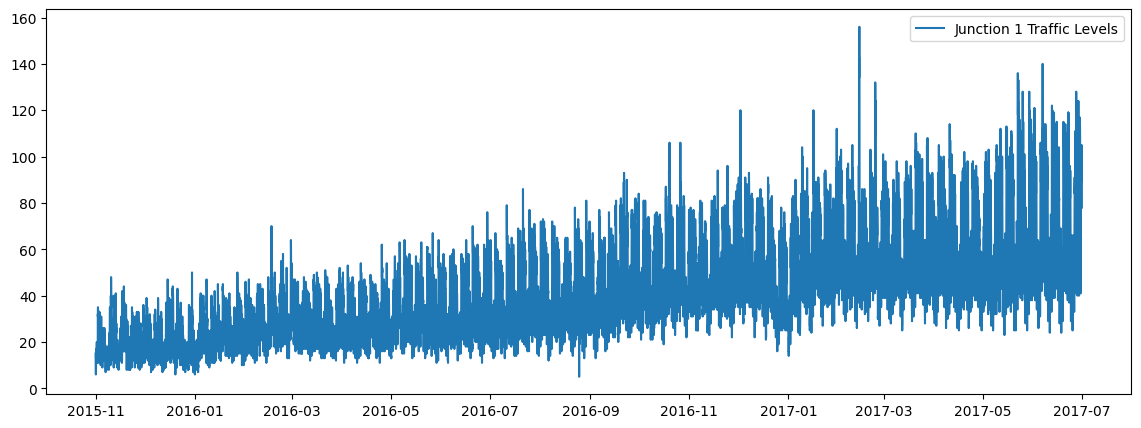

In [5]:
# Plot the traffic data for a specific junction
junction_id = 1  # Change this to the desired junction ID
junction_data = data[data['Junction'] == junction_id]

plt.figure(figsize=(14, 5))
plt.plot(junction_data['DateTime'], junction_data['Vehicles'], label=f'Junction {junction_id} Traffic Levels')
plt.legend()
plt.show()


In [6]:
# Sort data by DateTime
junction_data = junction_data.sort_values('DateTime')

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(junction_data[['Vehicles']])

# Define a function to create sequences for RNN
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])  # Predict the vehicle count
    return np.array(X), np.array(y)

# Define sequence length
seq_length = 60

# Create sequences
X, y = create_sequences(scaled_data, seq_length)

# Split into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape X to fit RNN input requirements
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [7]:
# Build the model
model = Sequential()
model.add(SimpleRNN(units=50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Display model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50)                2600      
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 2651 (10.36 KB)
Trainable params: 2651 (10.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/20
364/364 [==============================] - 7s 12ms/step - loss: 0.0069 - val_loss: 0.0029
Epoch 2/20
364/364 [==============================] - 5s 15ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 3/20
364/364 [==============================] - 6s 16ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 4/20
364/364 [==============================] - 4s 12ms/step - loss: 9.7554e-04 - val_loss: 0.0018
Epoch 5/20
364/364 [==============================] - 6s 17ms/step - loss: 9.1241e-04 - val_loss: 0.0017
Epoch 6/20
364/364 [==============================] - 4s 11ms/step - loss: 8.8788e-04 - val_loss: 0.0021
Epoch 7/20
364/364 [==============================] - 6s 18ms/step - loss: 8.5670e-04 - val_loss: 0.0013
Epoch 8/20
364/364 [==============================] - 4s 10ms/step - loss: 8.5681e-04 - val_loss: 0.0015
Epoch 9/20
364/364 [==============================] - 7s 20ms/step - loss: 8.4297e-04 - val_loss: 0.0016
Epoch 10/20
364/364 [==============================] - 3s 9ms/step 

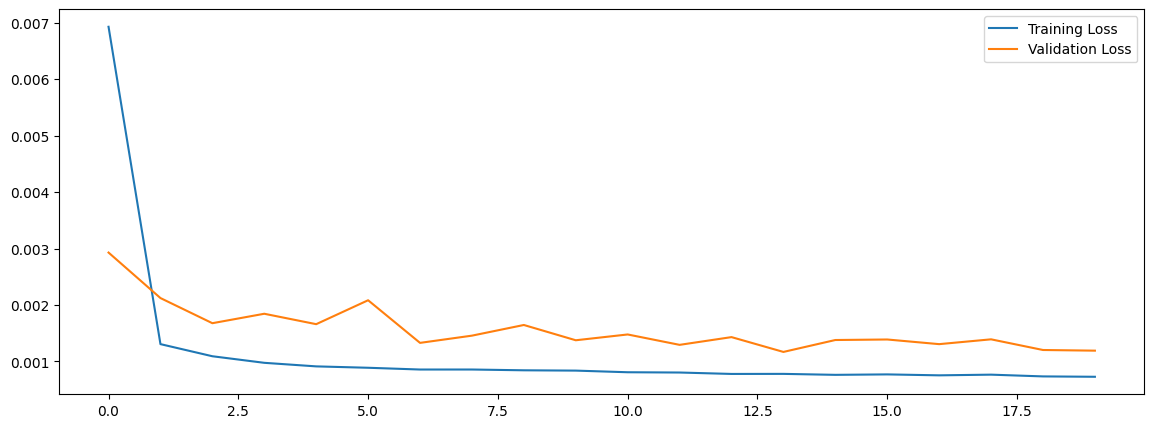

In [8]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Plot training history
plt.figure(figsize=(14, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


91/91 [==============================] - 1s 3ms/step


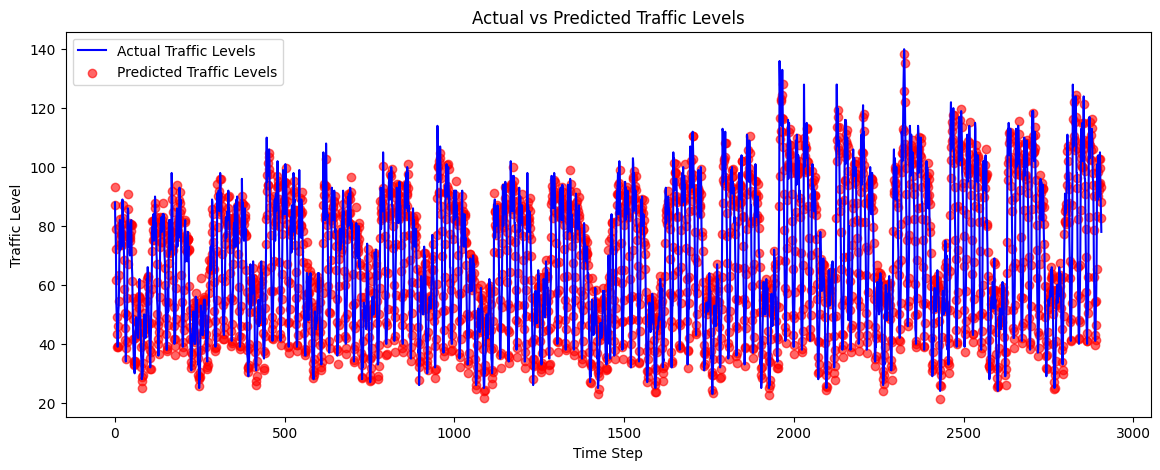

In [9]:
# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot predictions vs actual values
plt.figure(figsize=(14, 5))
plt.plot(y_test_actual, label='Actual Traffic Levels', color='blue')
plt.scatter(range(len(predictions)), predictions, label='Predicted Traffic Levels', color='red', alpha=0.6)
plt.legend()
plt.title('Actual vs Predicted Traffic Levels')
plt.xlabel('Time Step')
plt.ylabel('Traffic Level')
plt.show()


In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate performance metrics
mse = mean_squared_error(y_test_actual, predictions)
mae = mean_absolute_error(y_test_actual, predictions)
r2 = r2_score(y_test_actual, predictions)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')


Mean Squared Error: 27.154614828458193
Mean Absolute Error: 3.7894616089287108
R-squared: 0.9514163397930573


In [11]:
# Define a function to calculate accuracy within a certain tolerance
def calculate_accuracy(actual, predicted, tolerance=0.10):
    within_tolerance = np.abs((actual - predicted) / actual) < tolerance
    accuracy = np.mean(within_tolerance) * 100
    return accuracy

# Calculate accuracy
tolerance = 0.10  # 10% tolerance
accuracy = calculate_accuracy(y_test_actual, predictions, tolerance)

print(f'Accuracy within ±{tolerance*100}%: {accuracy:.2f}%')


Accuracy within ±10.0%: 81.80%


In [12]:
# Get the last sequence from the data
last_sequence = scaled_data[-seq_length:]
last_sequence = np.expand_dims(last_sequence, axis=0)  # Reshape to match model input

# Predict the next day's traffic level
next_day_prediction = model.predict(last_sequence)
next_day_prediction = scaler.inverse_transform(next_day_prediction)

print(f'Predicted traffic level for the next day: {next_day_prediction[0][0]}')


1/1 [==============================] - 0s 27ms/step
Predicted traffic level for the next day: 73.5040054321289


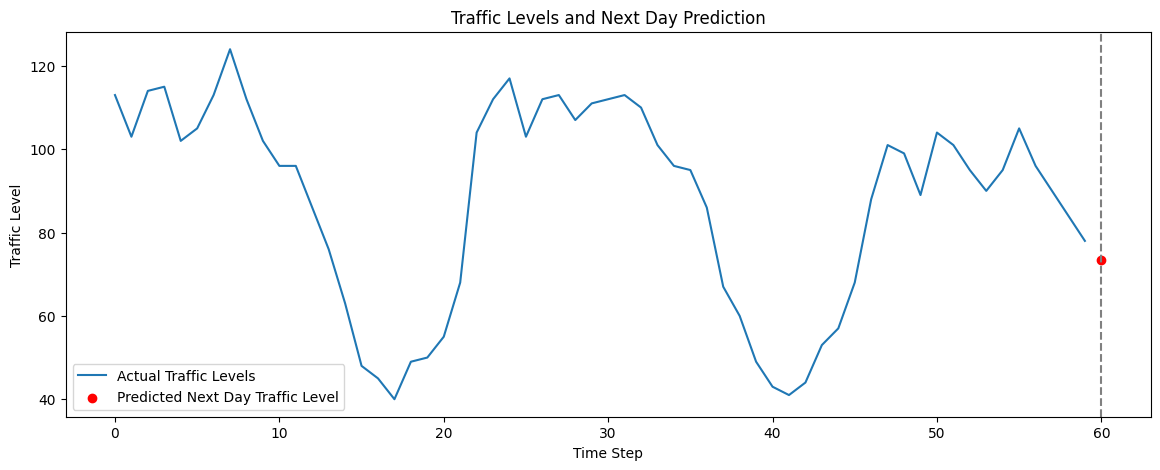

In [13]:
# Get the actual traffic levels for the last seq_length days
last_actual = scaler.inverse_transform(scaled_data[-seq_length:])[:, 0]

# Plot the actual traffic levels and the predicted value
plt.figure(figsize=(14, 5))
plt.plot(range(seq_length), last_actual, label='Actual Traffic Levels')
plt.scatter(seq_length, next_day_prediction, color='red', label='Predicted Next Day Traffic Level')
plt.axvline(x=seq_length, color='gray', linestyle='--')
plt.legend()
plt.title('Traffic Levels and Next Day Prediction')
plt.xlabel('Time Step')
plt.ylabel('Traffic Level')
plt.show()
